**DO NOT DOWNLOAD THIS NOTEBOOK.**

The package requirements are rather specific because of updates to numpy and scipy which broke `fastsparsegams`.

Please do not come to the TA team with package issues on your local machine.

Useful links:

[FastSparseGams PyPI page](https://pypi.org/project/fastsparsegams/)


[Scikit Learn Random Forest Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

[Scikit Learn AdaBoost Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)


[XGBoost Documentation](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)

[InterpretML ExplainableBoostingClassifier Documentation](https://interpret.ml/docs/python/api/ExplainableBoostingClassifier.html)

[GAMChanger](https://interpret.ml/gam-changer/)


# Homework 2, Problem 3

## GAMs and the Rashomon Effect

### Setup (all provided, do not modify)

#### Package dependencies and imports

In [1]:
# ensures that fastsparsegams can run
# fastsparsegams has been marred by the
# sinister appetite of software deprecation
!pip install 'numpy<2.0'
# This will throw an error but it will still work. Don't be scared of the red.
!pip install 'scipy<1.13.0'
!pip install fastsparsegams

!pip install ucimlrepo
!pip install interpret gamchanger

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 26.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 55.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.12.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 116.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 41.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

import gamchanger as gc
from interpret.glassbox import ExplainableBoostingClassifier

import fastsparsegams as fsg

#### Helper Functions You **Won't** Need To Use Yourself

In [3]:
# This code is pulled straight from the l0learn/fastsparsegams package.
# We'll use this to setup our binary data for fastsparsegams.
def convert_continuous_df_to_binary_df(df):
    """Convert continuous features to binary features in the dataframe.

    Generates 100 percentile thresholds for each feature.

    Parameters:
        df (pandas.DataFrame): The input dataframe containing continuous features.

    Returns:
        pandas.DataFrame: The binary dataframe with converted features.
    """
    colnames = df.columns
    n = len(df)
    print("Make sure your first column corresponds to the y label")
    print("Converting continuous features to binary features in the dataframe......")

    percentile_ticks = range(1, 101)

    binarized_dict = {}

    for i in range(0, len(colnames)):
        uni = df[colnames[i]].unique()
        if len(uni) == 2:
            binarized_dict[colnames[i]] = np.asarray(df[colnames[i]], dtype=int)
            continue

        uni.sort()
        if len(uni) >= 100:
            uni = np.percentile(uni, percentile_ticks)
        for j in range(len(uni) - 1):
            tmp_feature = np.ones(n, dtype=int)
            tmp_name = colnames[i] + "<=" + str(uni[j])

            zero_indices = df[colnames[i]] > uni[j]
            tmp_feature[zero_indices] = 0

            binarized_dict[tmp_name] = tmp_feature

    binarized_df = pd.DataFrame(binarized_dict)
    print("Finish converting continuous features to binary features......")
    return binarized_df

In [4]:
# THIS CELL CONTAINS HELPER FUNCTIONS FOR THE TWO PROVIDED PLOTTING UTILITIES.
# YOU DON'T NEED TO DIRECTLY USE ANY OF THESE.

def get_xgb_tree_coeffs(xgb_model):
    """Get the coefficients of the decision tree splits in an XGBoost model.

    Parameters:
        xgb_model: The trained XGBoost model.

    Returns:
        pandas.DataFrame: The coefficients of the decision tree splits.
    """
    booster = xgb_model.get_booster()
    # get the features that are used in the xgboost model and their splits
    tree_df = booster.trees_to_dataframe()

    better_tree_df = tree_df[tree_df['Feature'] != 'Leaf'].copy()
    better_tree_df.loc[:, '< coeff'] = tree_df.loc[tree_df['Node'] == 1, 'Gain'].to_numpy()
    better_tree_df.loc[:, '> coeff'] = tree_df.loc[tree_df['Node'] == 2, 'Gain'].to_numpy()
    return better_tree_df[["Feature", "Split", "< coeff", "> coeff"]]


def extract_stump_info(stump: tree.DecisionTreeClassifier):
    """Get the feature, threshold value, and the predictions at each leaf node
    for a decision stump implemented in scikit-learn's DecisionTreeClassifier format.

    Parameters:
        stump (tree.DecisionTreeClassifier): The decision stump.

    Returns:
        tuple: A tuple containing the feature, threshold value,
            and the predictions at each leaf node.
    """
    feature = stump.tree_.feature[0]
    threshold = stump.tree_.threshold[0]

    leq_values = stump.tree_.value[1][0]
    gt_values = stump.tree_.value[2][0]

    return feature, threshold, leq_values, gt_values


def get_sklearn_adaboost_coeffs(adaboost, columns):
    """Get the coefficients of the decision tree splits in an AdaBoost model.

    Parameters:
        adaboost: The trained AdaBoost model.
        columns: The column names of the input data.

    Returns:
        pandas.DataFrame: The coefficients of the decision tree splits.
    """

    features, thresholds, leq_preds, gt_preds = [], [], [], []
    weights = adaboost.estimator_weights_
    for i, dtree in enumerate(adaboost.estimators_):
        feature, threshold, leq_values, gt_values = extract_stump_info(dtree)
        features.append(columns[feature])
        thresholds.append(threshold)
        leq_preds.append(np.argmax(leq_values) * weights[i])
        gt_preds.append(np.argmax(gt_values) * weights[i])
    adaboost_coeffs = pd.DataFrame({
        "Feature": features,
        "Split": thresholds,
        "< coeff": leq_preds,
        "> coeff": gt_preds
    })
    return adaboost_coeffs


def get_sklearn_rf_coeffs(rf, columns):
    """Get the coefficients of the decision tree splits in a tree-based sklearn ensemble.

    Parameters:
        rf: The trained random forest model.
        columns: The column names of the input data.

    Returns:
        pandas.DataFrame: The coefficients of the decision tree splits.
    """
    features, thresholds, leq_preds, gt_preds = [], [], [], []
    for dtree in rf.estimators_:
        feature, threshold, leq_values, gt_values = extract_stump_info(dtree)
        features.append(columns[feature])
        thresholds.append(threshold)
        leq_preds.append(leq_values[1] / (leq_values[0] + leq_values[1]))
        gt_preds.append(gt_values[1] / (gt_values[0] + gt_values[1]))
    rf_coeffs = pd.DataFrame({"Feature": features, "Split": thresholds, "< coeff": leq_preds, "> coeff": gt_preds})
    return rf_coeffs


def convert_coefficients_to_shape_function(coefficients, direction="<"):
    """Convert the gam feature coefficients to a step/shape function.

    This is needed to make the coefficient representation conform to the
    alignment expectations of plt.step, which are somewhat unintuitive.
    You can figure out how to do this yourself with a whiteboard and some patience,
    but I did that for you :)

    Parameters:
        coefficients (list[float]): The coefficients of the shape function.
        direction (str, optional): The direction of the step function.
            Can be "<" or ">". Defaults to "<".

    Returns:
        list[float]: The step function coefficients.
    """
    coefficients_steps = np.zeros(len(coefficients)+2)
    if direction == "<":
        coeff_reverse_cumsum = np.cumsum(coefficients[::-1])[::-1]
        coefficients_steps[1:-1] = coeff_reverse_cumsum
        coefficients_steps[0] = coeff_reverse_cumsum[0]
    else:
        coeff_cumsum = np.cumsum(coefficients)
        coefficients_steps[2:] = coeff_cumsum
    return coefficients_steps


def plot_shape_function(steps: list[float], coefficients: list[float], feature_name: str, ax=None):
    """Plot the shape function of the GAM for a single feature.

    The shape function is a piecewise constant function that is the sum of the coefficients
    where the feature value is less than or equal to the step (or greater than).

    Parameters:
        steps (list[float]): The steps in the shape function. Assume these are sorted in ascending order.
        coefficients (list[float]): The coefficients of the shape function.
        feature_name (str): The name of the feature.
        ax (matplotlib.axes.Axes, optional): The axes on which to plot the shape function.
            If not provided, a new figure and axes will be created.

    Returns:
        None
    """
    if ax is None:
        fig, ax = plt.subplots()
    ax.step(steps, coefficients, where="pre")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Shape function")
    ax.set_title(f"Shape function for {feature_name}")

#### Helper Functions You **Will** Need To Use Yourself

In [5]:
def plot_shape_functions_fastsparse(gam, binary_cols, continuous_df, lambda_0=0):
    """Plot the shape functions of a GAM model using the fastsparse package.

    Parameters:
        gam: The trained GAM model.
        binary_cols: The binary column names used in the GAM model.
        continuous_df: The continuous dataframe used in the GAM model.
        lambda_0 (float, optional): The regularization parameter. Defaults to 0.

    Returns:
        None
    """
    gam_coeffs = gam.coeff(lambda_0=lambda_0)
    intercept = gam_coeffs[0]
    coefficients = gam_coeffs[1:]
    used_binary_features = binary_cols[coefficients.indices]
    feature_names = np.unique([feature.split("<=")[0] for feature in used_binary_features])
    print(intercept)

    n_features = len(feature_names)
    ncols = min(3, n_features)
    nrows = int(np.ceil(n_features / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
    axes = np.array(axes).reshape(-1)

    for idx, feature_name in enumerate(feature_names):
        feature_indices = [i for i, feature in enumerate(used_binary_features) if feature_name in feature]
        feature_min = continuous_df[feature_name].min()
        feature_max = continuous_df[feature_name].max()
        steps = [float(feature.split("<=")[1]) for feature in used_binary_features[feature_indices]]
        steps = [feature_min] + steps + [feature_max]

        coefficients_lte = gam_coeffs.data[feature_indices]
        coefficients_lte_steps = convert_coefficients_to_shape_function(coefficients_lte, direction="<")
        coefficients = coefficients_lte_steps

        plot_shape_function(steps, coefficients, feature_name, ax=axes[idx])

    # Hide unused axes
    for j in range(len(feature_names), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


def plot_shape_functions_tree_ensemble(ensemble, continuous_df):
    """Plot the shape functions of a tree ensemble model.

    Parameters:
        ensemble: The decision tree ensemble.
        continuous_df: The continuous dataframe used in the tree ensemble model.

    Returns:
        None
    """
    if isinstance(ensemble, AdaBoostClassifier):
        ensemble_df = get_sklearn_adaboost_coeffs(ensemble, continuous_df.columns)
    elif isinstance(ensemble, RandomForestClassifier):
        ensemble_df = get_sklearn_rf_coeffs(ensemble, continuous_df.columns)
    elif isinstance(ensemble, XGBClassifier):
        ensemble_df = get_xgb_tree_coeffs(ensemble)
    else:
        raise ValueError("Only AdaBoost, RandomForest, and XGBoost models are supported")

    feature_names = np.unique(ensemble_df['Feature'])
    n_features = len(feature_names)
    ncols = min(3, n_features)
    nrows = int(np.ceil(n_features / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
    axes = np.array(axes).reshape(-1)

    for idx, feature_name in enumerate(feature_names):
        feature_df = ensemble_df[ensemble_df['Feature'] == feature_name].sort_values('Split')
        steps = feature_df['Split'].to_numpy()

        feature_min = continuous_df[feature_name].min()
        feature_max = continuous_df[feature_name].max()
        steps = [feature_min] + list(steps) + [feature_max]

        coefficients_lt = feature_df['< coeff'].to_numpy()
        coefficients_gte = feature_df['> coeff'].to_numpy()
        coefficients_lt_steps = convert_coefficients_to_shape_function(coefficients_lt, direction="<")
        coefficients_gte_steps = convert_coefficients_to_shape_function(coefficients_gte, direction=">")
        coefficients = coefficients_lt_steps + coefficients_gte_steps

        plot_shape_function(steps, coefficients, feature_name, ax=axes[idx])

    # Hide unused axes
    for j in range(len(feature_names), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

#### Setup Data (Please read)

For this homework assignment, we will use a dataset which has various chemical measurements about wine, used to predict wine quality. The task is to predict whether or not the wine will be assigned a quality of "average" (6) or better.

We separate the data out into train/validation/test splits of sizes 75/10/15%, respectively.

In [6]:
# fetch dataset
wine_dataset = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_dataset.data.features
y = wine_dataset.data.targets

y = (y >= 6).astype(int)

# split into 15% test, 10% validation, 75% train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/(1-.15), random_state=43)

X_train

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
1337,6.0,0.500,0.00,1.4,0.057,15.0,26.0,0.99448,3.36,0.45,9.5
4708,6.9,0.300,0.36,4.5,0.054,31.0,203.0,0.99513,3.40,0.57,10.4
1892,6.2,0.280,0.22,7.3,0.041,26.0,157.0,0.99570,3.44,0.64,9.8
5192,5.6,0.280,0.28,4.2,0.044,52.0,158.0,0.99200,3.35,0.44,10.7
1331,7.8,0.870,0.26,3.8,0.107,31.0,67.0,0.99668,3.26,0.46,9.2
...,...,...,...,...,...,...,...,...,...,...,...
4840,5.8,0.300,0.42,1.1,0.036,19.0,113.0,0.98871,3.10,0.46,12.6
5529,6.1,0.280,0.26,1.5,0.030,25.0,101.0,0.98894,3.03,0.41,12.1
1213,9.6,0.380,0.42,1.9,0.071,5.0,13.0,0.99659,3.15,0.75,10.5
1812,6.7,0.130,0.29,5.3,0.051,31.0,122.0,0.99440,3.44,0.37,9.7


We use a utility provided by the `fastsparsegams` library to binarize the data; this function splits the data into at most 100 percentile bins (fewer if the feature has less than 100 distinct values), where the feature value for a particular row is 1 if and only if it is less than or equal to the split value.
We take care to make sure we're using the same train/val/test splits as in the continuous data.

We do this for use by FastSparseGAMs, which does not internally binarize the data. If we just ran FastSparseGAMs with continuous data, it would give us a linear model over the features. We want to fit a GAM, not a linear model.

In [7]:
binary_df = convert_continuous_df_to_binary_df(pd.concat([y, X], axis=1))
X_binary = binary_df[binary_df.columns[1:]]
y_binary = binary_df[binary_df.columns[0]]

X_binary_train = X_binary.iloc[X_train.index]
y_binary_train = y_binary.iloc[X_train.index]

X_binary_val = X_binary.iloc[X_val.index]
y_binary_val = y_binary.iloc[X_val.index]

X_binary_test = X_binary.iloc[X_test.index]
y_binary_test = y_binary.iloc[X_test.index]

X_binary_train

Make sure your first column corresponds to the y label
Converting continuous features to binary features in the dataframe......
Finish converting continuous features to binary features......


,fixed_acidity<=3.915,fixed_acidity<=4.220000000000001,fixed_acidity<=4.415,fixed_acidity<=4.52,fixed_acidity<=4.625,fixed_acidity<=4.73,fixed_acidity<=4.835,fixed_acidity<=4.94,fixed_acidity<=5.045,fixed_acidity<=5.15,...,alcohol<=13.4,alcohol<=13.505,alcohol<=13.553333334000001,alcohol<=13.576666669,alcohol<=13.639999999999999,alcohol<=13.75,alcohol<=13.86,alcohol<=13.97,alcohol<=14.040000000000001,alcohol<=14.185
1337,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4708,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1892,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
5192,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1331,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4840,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
5529,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1213,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1812,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


### (a) Fitting a GAM using FastSparseGAMs on the binary training data.

In [8]:
# make sure the datatypes are correct to pass into fastsparsegams
X_train_fsg = X_binary_train.values.astype(float)
y_train_fsg = y_binary_train.values

In [15]:
# Part (a): Fitting a GAM using FastSparseGAMs

# Fit the GAM model
gam_model = fsg.fit(
    X_train_fsg,
    y_train_fsg,
    loss='Logistic',
    max_support_size=25,
    algorithm='CDPSI'
)

# Get the solution path characteristics
characteristics = gam_model.characteristics()

# Prepare validation data
X_val_fsg = X_binary_val.values.astype(float)
y_val_fsg = y_binary_val.values

# Evaluate all models in the solution path on validation set
best_val_acc = 0
best_lambda_0 = 0
best_support_size = 0

for i in range(len(characteristics['l0'])):
    lambda_0 = characteristics['l0'][i]
    support_size = characteristics['support_size'][i]

    # Make predictions on validation set
    y_val_pred_proba = gam_model.predict(X_val_fsg, lambda_0=lambda_0)

    # Convert probabilities to binary predictions (threshold at 0.5)
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)

    val_acc = accuracy_score(y_val_fsg, y_val_pred)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_lambda_0 = lambda_0
        best_support_size = support_size

print(f"Best model from solution path:")
print(f"Lambda_0: {best_lambda_0}")
print(f"Support size: {best_support_size}")
print(f"Validation accuracy: {best_val_acc:.4f}")

Best model from solution path:
Lambda_0: 18.695996247909573
Support size: 5
Validation accuracy: 0.7723


### (b) Explore the shape functions of the FastSparseGAMs model found in part (a).

The FastSparseGAMs model selected 4 key features that align well with wine
chemistry principles. Alcohol shows a strong positive relationship with quality,
with wines above 12% contributing positively to quality predictions. Volatile
acidity has a strong negative effect - wines with acidity below 0.4 g/L receive
a large positive boost (~3.1), reflecting that excessive volatile acidity creates
undesirable vinegar-like flavors. Free sulfur dioxide below 20mg/L the strongest positive
contribution, suggesting too little or too much SO2 both reduce quality. Finally,
sulphates show a positive relationship, with adequate levels (≥0.5 g/L) being
important for preservation.

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 1 stored elements and shape (1, 1)>
  Coords	Values
  (0, 0)	3.0627580991526546


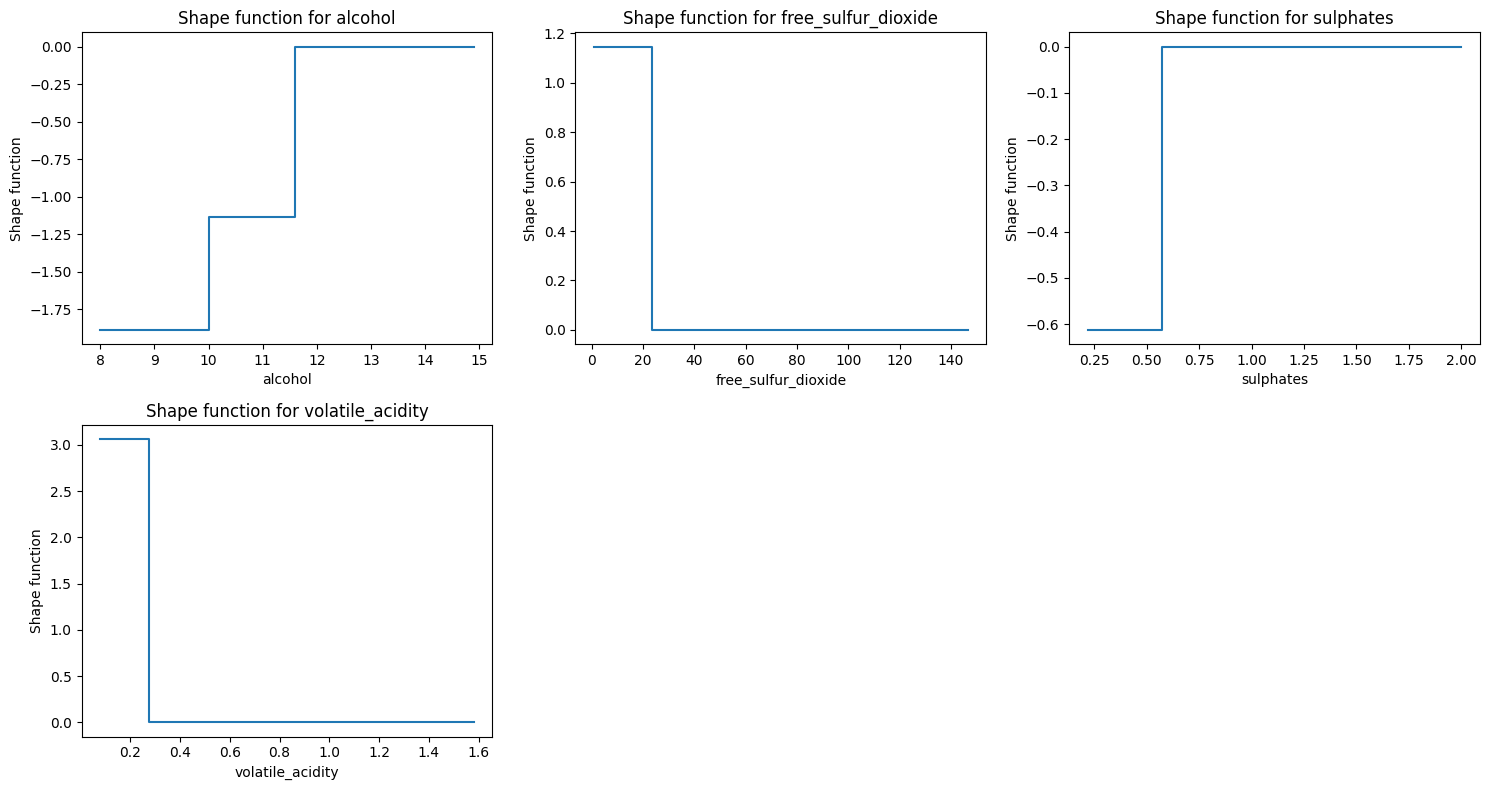

In [23]:
# Part (b): Plot shape functions for FastSparseGAMs model

plot_shape_functions_fastsparse(
    gam_model,
    X_binary_train.columns,
    X_train,
    lambda_0=best_lambda_0
)


### (c) Fit AdaBoost, XGBoost, and RandomForest classifiers on the continuous training data.

The three boosting-based approaches (FastSparseGAMs, AdaBoost, XGBoost) achieve
very similar validation accuracies (~77%), while Random Forest performs
significantly worse at only 60.8%. This performance gap likely occurs because AdaBoost and XGBoost use sequential boosting that
   focuses on correcting errors from previous stumps, while Random Forest uses
   bagging (parallel averaging). With max_depth=1 (single stumps), each random
   forest tree is extremely weak, and averaging many weak, independent stumps
   doesn't create strong predictive power.

In [20]:
# Part (c): Fit AdaBoost, XGBoost, and RandomForest classifiers

# Prepare data
X_train_continuous = X_train.values
y_train_continuous = y_train.values.ravel()
X_val_continuous = X_val.values
y_val_continuous = y_val.values.ravel()

# AdaBoost with decision stumps
print("Training AdaBoost...")
adaboost_model = AdaBoostClassifier(
    estimator=tree.DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    algorithm='SAMME',
    random_state=42
)
adaboost_model.fit(X_train_continuous, y_train_continuous)
adaboost_val_acc = accuracy_score(
    y_val_continuous,
    adaboost_model.predict(X_val_continuous)
)
print(f"AdaBoost validation accuracy: {adaboost_val_acc:.4f}")

# XGBoost with max_depth=1
print("\nTraining XGBoost...")
xgboost_model = XGBClassifier(
    max_depth=1,
    n_estimators=50,
    random_state=42,
    eval_metric='logloss'
)
xgboost_model.fit(X_train_continuous, y_train_continuous)
xgboost_val_acc = accuracy_score(
    y_val_continuous,
    xgboost_model.predict(X_val_continuous)
)
print(f"XGBoost validation accuracy: {xgboost_val_acc:.4f}")

# Random Forest with max_depth=1
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    max_depth=1,
    n_estimators=50,
    random_state=42
)
rf_model.fit(X_train_continuous, y_train_continuous)
rf_val_acc = accuracy_score(
    y_val_continuous,
    rf_model.predict(X_val_continuous)
)
print(f"Random Forest validation accuracy: {rf_val_acc:.4f}")

# Summary comparison
print("\n" + "="*50)
print("VALIDATION ACCURACY COMPARISON:")
print("="*50)
print(f"FastSparseGAMs:  {best_val_acc:.4f}")
print(f"AdaBoost:        {adaboost_val_acc:.4f}")
print(f"XGBoost:         {xgboost_val_acc:.4f}")
print(f"Random Forest:   {rf_val_acc:.4f}")

Training AdaBoost...


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost validation accuracy: 0.7662

Training XGBoost...
XGBoost validation accuracy: 0.7646

Training Random Forest...
Random Forest validation accuracy: 0.6077

VALIDATION ACCURACY COMPARISON:
FastSparseGAMs:  0.7723
AdaBoost:        0.7662
XGBoost:         0.7646
Random Forest:   0.6077


### (d) Plot the shape functions of these three approaches and compare them to those of the model produced by FastSparseGAMs.

Comparing the shape functions across all four methods reveals that while the
general directional trends agree (alcohol increases quality, volatile acidity
decreases quality), the tree ensemble methods (AdaBoost, XGBoost, RandomForest)
produce shape functions with many more steps and splits compared to FastSparseGAMs'
sparser representations. The ensemble methods' shapes are not strictly monotonic.
They have local variations and noise due to how decision stumps aggregate, whereas
FastSparseGAMs enforces cleaner, more regularized patterns through L0 regularization.
Despite these differences in shape complexity and exact split points, all three
boosting methods achieve similar validation accuracy (~77%), demonstrating the
Rashomon effect: multiple models with different representations can capture the
same underlying relationships equally well. My intuitions about feature impact
(alcohol positive, volatile acidity negative) hold consistently across methods,
though the exact magnitude and form of these relationships varies, suggesting
these directional effects are robust while the precise functional form is flexible.


1. FastSparseGAMs Shape Functions:
<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 1 stored elements and shape (1, 1)>
  Coords	Values
  (0, 0)	3.0627580991526546


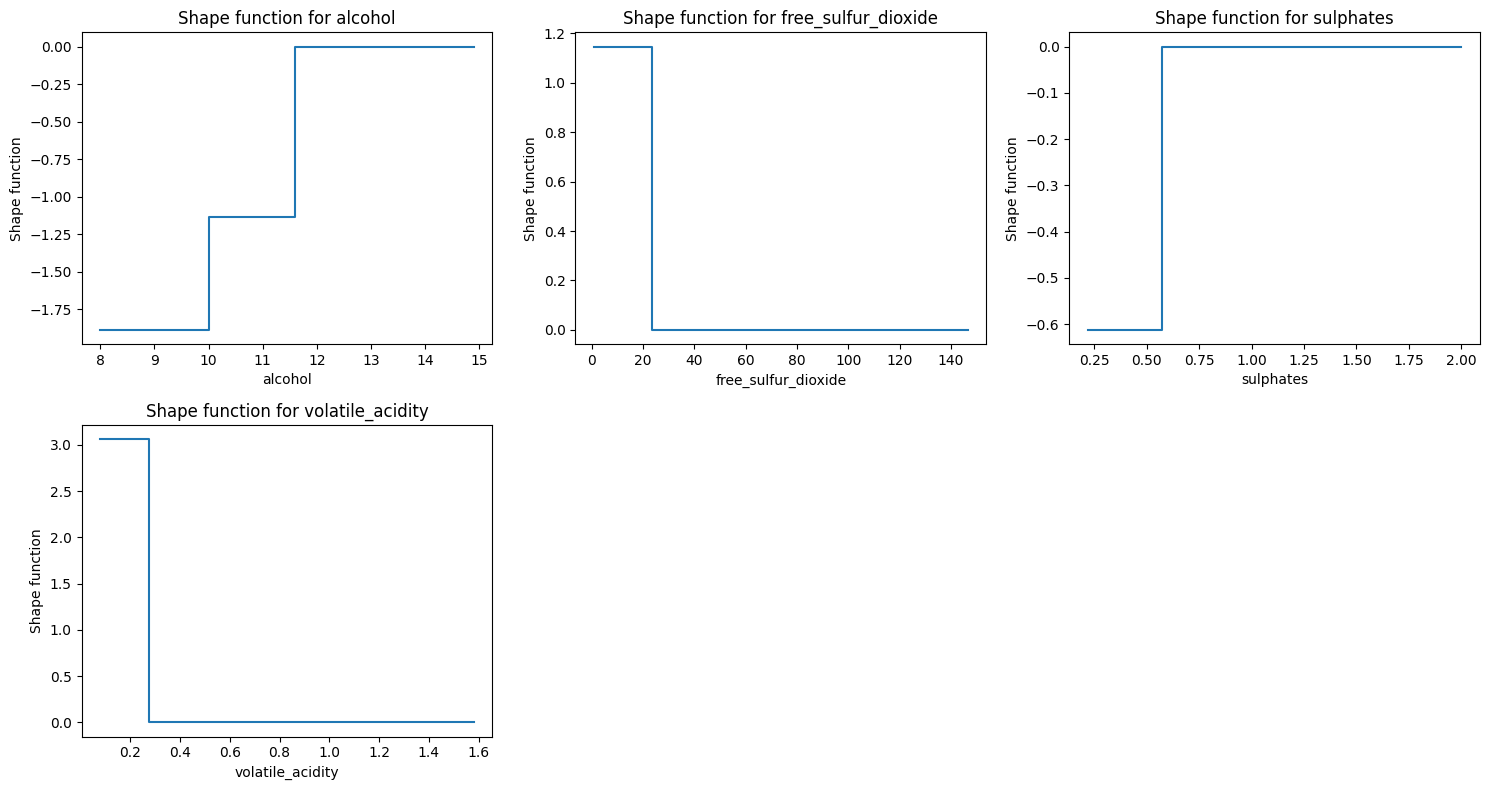


2. AdaBoost (SAMME) Shape Functions:


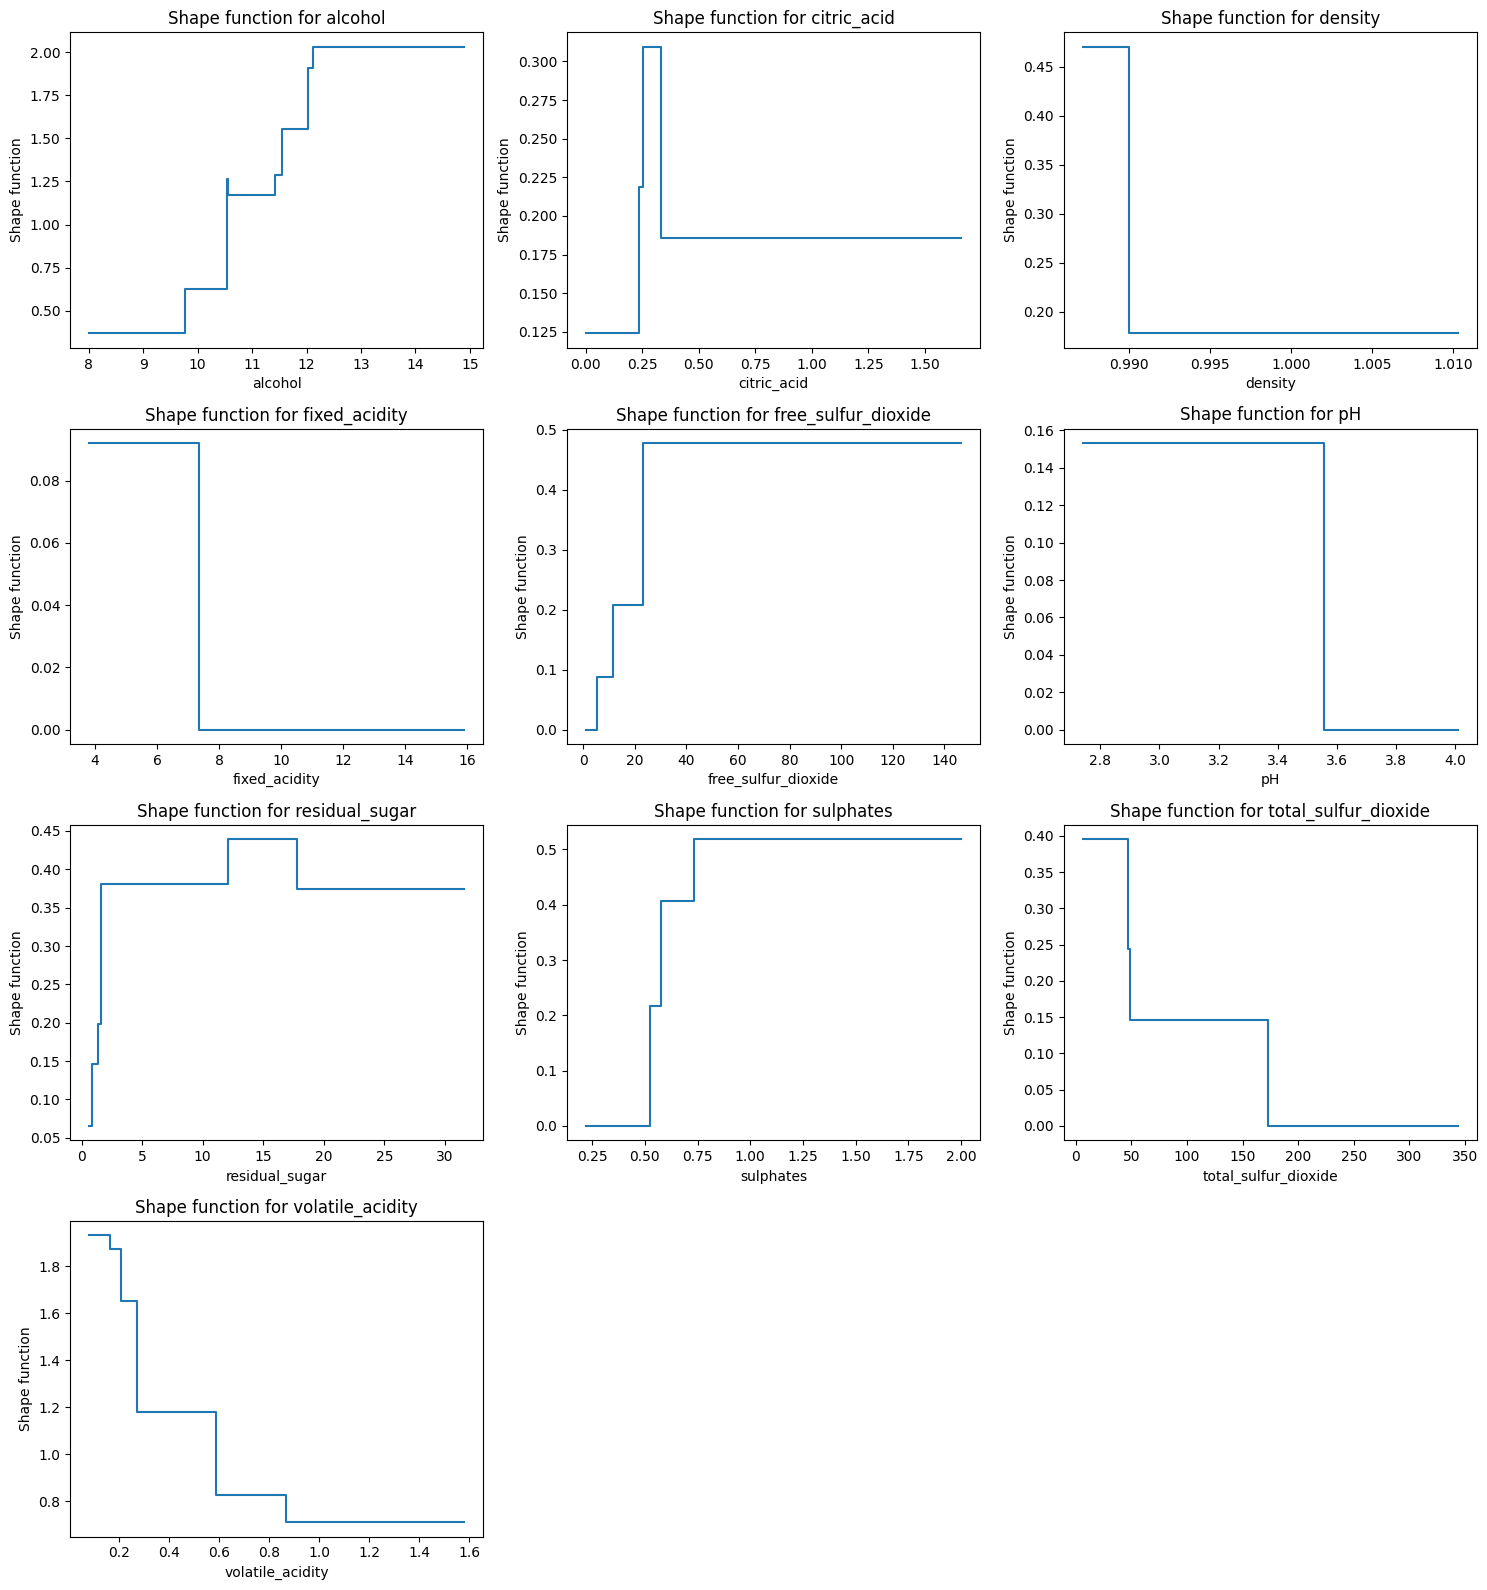


3. XGBoost (depth=1) Shape Functions:


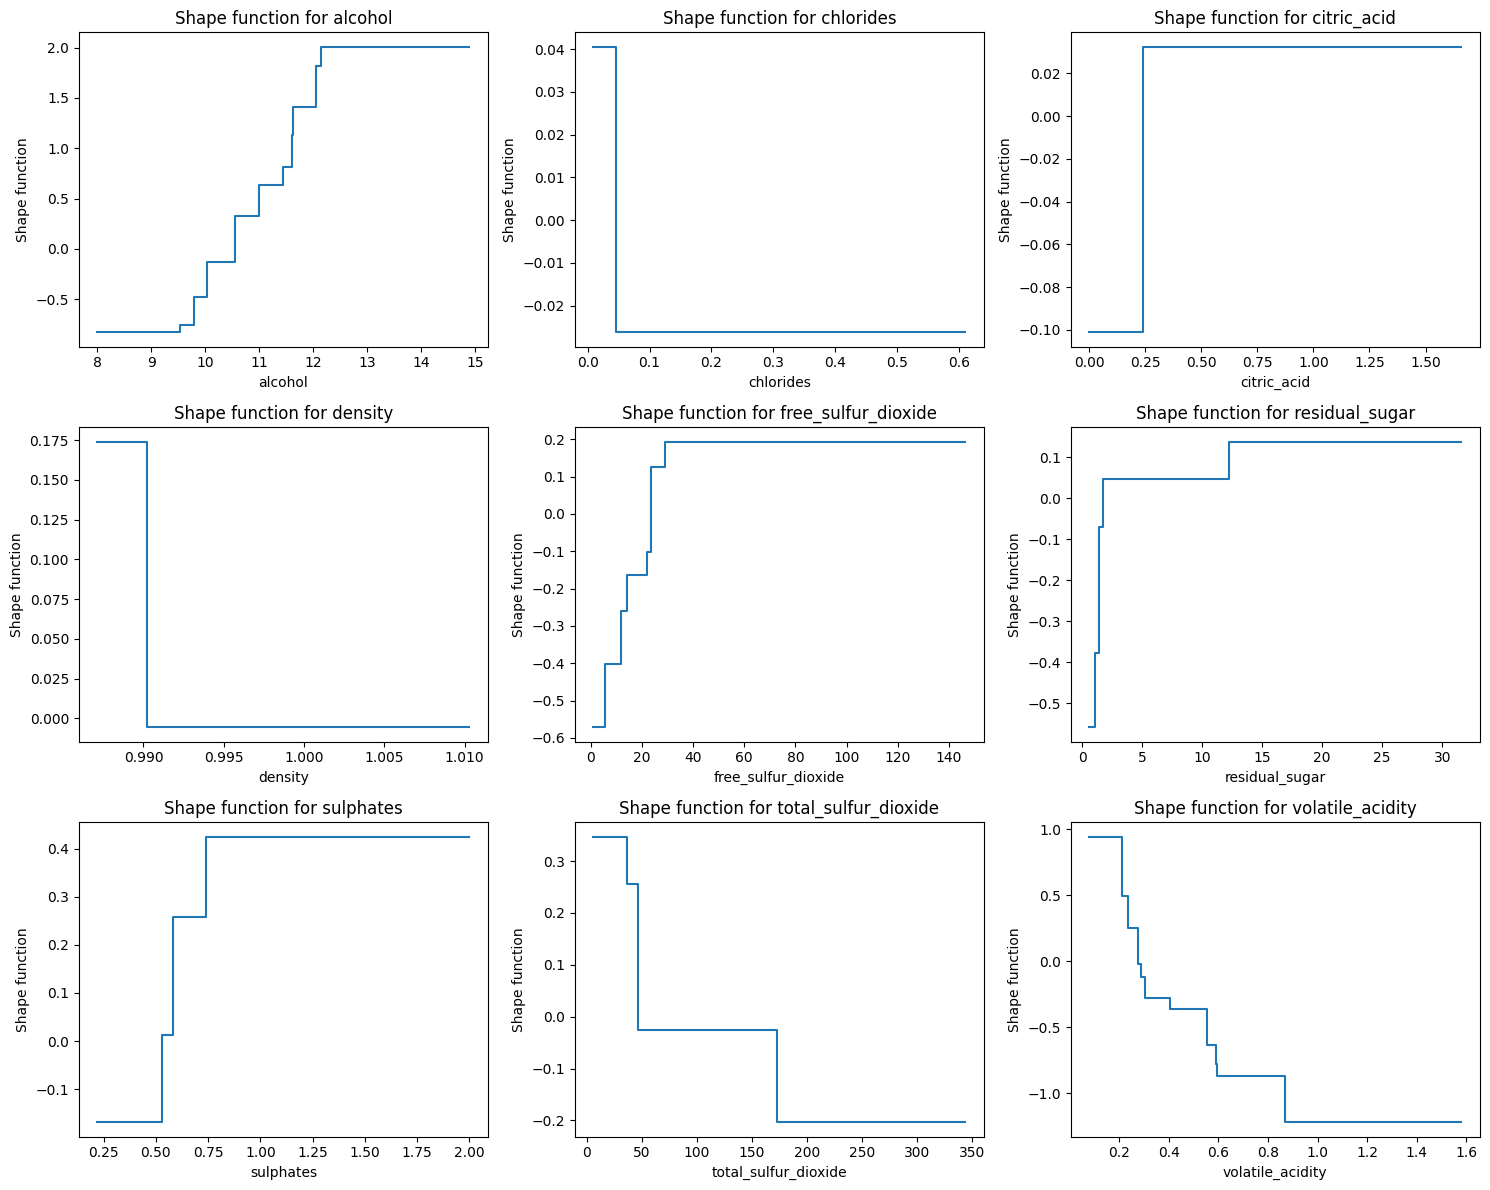


4. Random Forest (depth=1) Shape Functions:


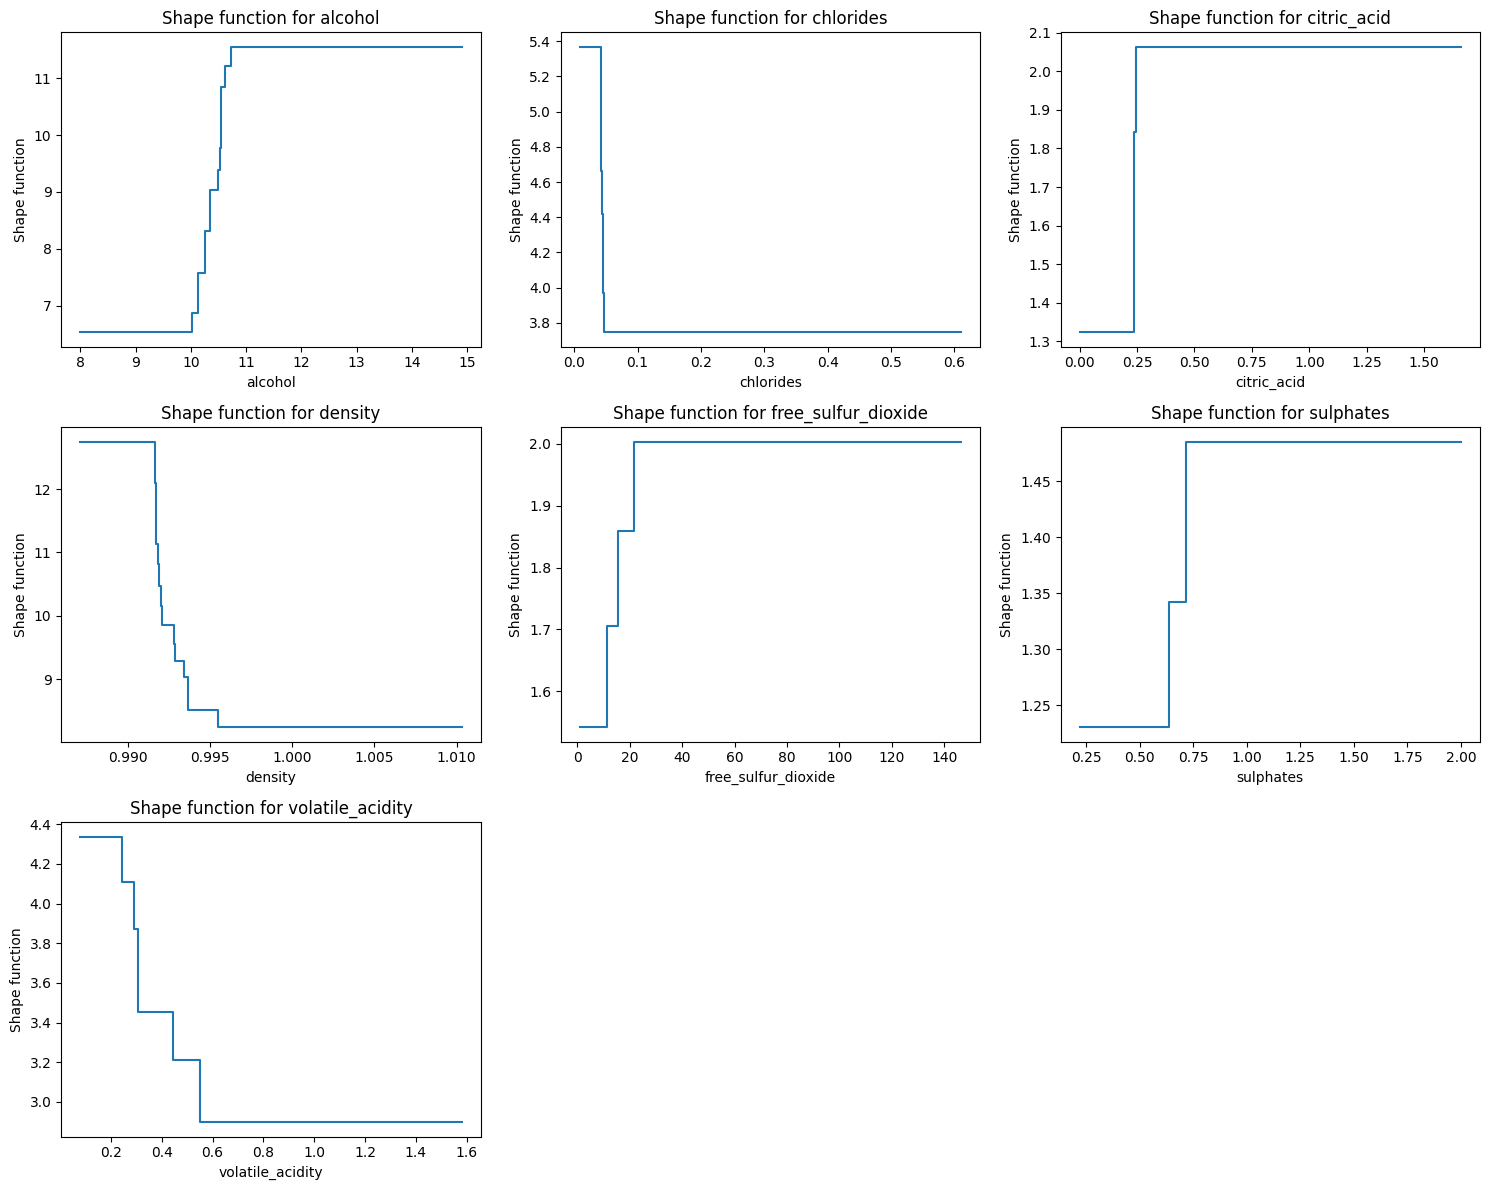

In [29]:
def _map_xgb_feature_name_to_df(name, df_columns):
    if isinstance(name, str) and name.startswith("f") and name[1:].isdigit():
        idx = int(name[1:])
        if 0 <= idx < len(df_columns):
            return df_columns[idx]
    return name

# Re-define plot_shape_functions_tree_ensemble with the mapping for XGB
def plot_shape_functions_tree_ensemble(ensemble, continuous_df):
    if isinstance(ensemble, AdaBoostClassifier):
        ensemble_df = get_sklearn_adaboost_coeffs(ensemble, continuous_df.columns)
    elif isinstance(ensemble, RandomForestClassifier):
        ensemble_df = get_sklearn_rf_coeffs(ensemble, continuous_df.columns)
    elif isinstance(ensemble, XGBClassifier):
        ensemble_df = get_xgb_tree_coeffs(ensemble)
        # --- map 'fN' -> actual column names from the DF ---
        cols = list(continuous_df.columns)
        ensemble_df["Feature"] = ensemble_df["Feature"].map(lambda s: _map_xgb_feature_name_to_df(s, cols))
    else:
        raise ValueError("Only AdaBoost, RandomForest, and XGBoost models are supported")

    feature_names = np.unique(ensemble_df['Feature'])
    n_features = len(feature_names)
    ncols = min(3, n_features)
    nrows = int(np.ceil(n_features / ncols)) if n_features > 0 else 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
    axes = np.array(axes).reshape(-1)

    for idx, feature_name in enumerate(feature_names):
        feature_df = ensemble_df[ensemble_df['Feature'] == feature_name].sort_values('Split')
        if feature_df.empty:
            axes[idx].axis("off")
            continue

        steps = feature_df['Split'].to_numpy()

        # use min/max from the original continuous feature to extend the step plot
        feature_min = continuous_df[feature_name].min()
        feature_max = continuous_df[feature_name].max()
        steps = [feature_min] + list(steps) + [feature_max]

        coefficients_lt = feature_df['< coeff'].to_numpy()
        coefficients_gte = feature_df['> coeff'].to_numpy()
        coefficients_lt_steps = convert_coefficients_to_shape_function(coefficients_lt, direction="<")
        coefficients_gte_steps = convert_coefficients_to_shape_function(coefficients_gte, direction=">")
        coefficients = coefficients_lt_steps + coefficients_gte_steps

        plot_shape_function(steps, coefficients, feature_name, ax=axes[idx])

    # Hide any unused axes
    for j in range(n_features, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()
print("\n1. FastSparseGAMs Shape Functions:")
plot_shape_functions_fastsparse(
    gam_model,
    X_binary_train.columns,
    X_train,
    lambda_0=best_lambda_0
)

print("\n2. AdaBoost (SAMME) Shape Functions:")
plot_shape_functions_tree_ensemble(adaboost_model, X_train)

print("\n3. XGBoost (depth=1) Shape Functions:")
plot_shape_functions_tree_ensemble(xgboost_model, X_train)

print("\n4. Random Forest (depth=1) Shape Functions:")
plot_shape_functions_tree_ensemble(rf_model, X_train)

### (5) Explore GAMs using GAMChanger.

I enforced monotonicity constraints on three features: made alcohol monotonically
increasing (higher alcohol improves quality), volatile acidity monotonically
decreasing (excess acidity creates vinegar taste), and total sulfur dioxide
monotonically decreasing (too much causes off-flavors). These substantial
structural changes to the shape functions resulted in only a 0.002 change in
validation accuracy, demonstrating that the Rashomon set for this problem is
extremely large. The fact that I could make major edits informed by domain
knowledge while maintaining essentially identical predictive performance shows
that many different model configurations are equally valid. This means we
shouldn't over-interpret any single model's exact shape functions, but rather
we should leverage this flexibility to select models that align with expert
knowledge about wine chemistry while still achieving strong accuracy (~77%).


In [31]:
print("\nTraining Explainable Boosting Classifier...")
ebc_model = ExplainableBoostingClassifier(
    interactions=0,  # No interaction terms
    random_state=42
)

# Fit on training data
ebc_model.fit(X_train, y_train.values.ravel())

# Evaluate on validation set
ebc_val_pred = ebc_model.predict(X_val)
ebc_val_acc = accuracy_score(y_val.values.ravel(), ebc_val_pred)

gc.visualize(ebc_model, X_val, y_val.values.ravel())


Training Explainable Boosting Classifier...


11it [00:00, 1621.41it/s]


<iframe
 srcdoc="<!DOCTYPE html><html lang="en"><head><meta charset='utf-8'><meta name='viewport' content='width = device-width, initial-scale = 1'><title>GAM Changer</title><style>html,body{position:relative;width:100%;height:100%}body{color:#333;margin:0;padding:0;box-sizing:border-box;font-family:-apple-system,BlinkMacSystemFont,"Segoe UI",Roboto,Oxygen-Sans,Ubuntu,Cantarell,"Helvetica Neue",sans-serif}a{color:rgb(0,100,200);text-decoration:none}a:hover{text-decoration:underline}a:visited{color:rgb(0,80,160)}label{display:block}input,button,select,textarea{font-family:inherit;font-size:inherit;-webkit-padding:0.4em 0;padding:0.4em;margin:0 0 0.5em 0;box-sizing:border-box;border:1px solid #ccc;border-radius:2px}input:disabled{color:#ccc}</style><script defer src='data:text/javascript;base64,IWZ1bmN0aW9uKHQsZSl7Im9iamVjdCI9PXR5cGVvZiBleHBvcnRzJiYidW5kZWZpbmVkIiE9dHlwZW9mIG1vZHVsZT9tb2R1bGUuZXhwb3J0cz1lKCk6ImZ1bmN0aW9uIj09dHlwZW9mIGRlZmluZSYmZGVmaW5lLmFtZD9kZWZpbmUoZSk6KHQ9InVuZGVmaW5lZCIhPXR5cGVvZiBnbG9iYWxUaGlzP2dsb2JhbFRoaXM6dHx8c2VsZikuYXBwPWUoKX0odGhpcywoZnVuY3Rpb24oKXsidXNlIHN0cmljdCI7ZnVuY3Rpb24gdCgpe31jb25zdCBhPXQ9PnQ7ZnVuY3Rpb24gbih0KXtyZXR1cm4gdCgpfWZ1bmN0aW9uIEEoKXtyZXR1cm4gT2JqZWN0LmNyZWF0ZShudWxsKX1mdW5jdGlvbiBpKHQpe3QuZm9yRWFjaChuKX1mdW5jdGlvbiByKHQpe3JldHVybiJmdW5jdGlvbiI9PXR5cGVvZiB0fWZ1bmN0aW9uIGwodCxlKXtyZXR1cm4gdCE9dD9lPT1lOnQhPT1lfHx0JiYib2JqZWN0Ij09dHlwZW9mIHR8fCJmdW5jdGlvbiI9PXR5cGVvZiB0fWZ1bmN0aW9uIG8oZSxhLG4pe2UuJCQub25fZGVzdHJveS5wdXNoKGZ1bmN0aW9uKGUsLi4uYSl7aWYobnVsbD09ZSlyZXR1cm4gdDtjb25zdCBuPWUuc3Vic2NyaWJlKC4uLmEpO3JldHVybiBuLnVuc3Vic2NyaWJlPygpPT5uLnVuc3Vic2NyaWJlKCk6bn0oYSxuKSl9ZnVuY3Rpb24gcyh0KXtyZXR1cm4gbnVsbD09dD8iIjp0fWNvbnN0IGM9InVuZGVmaW5lZCIhPXR5cGVvZiB3aW5kb3c7bGV0IGc9Yz8oKT0+d2luZG93LnBlcmZvcm1hbmNlLm5vdygpOigpPT5EYXRlLm5vdygpLHU9Yz90PT5yZXF1ZXN0QW5pbWF0aW9uRnJhbWUodCk6dDtjb25zdCBkPW5ldyBTZXQ7ZnVuY3Rpb24gaCh0KXtkLmZvckVhY2goKGU9PntlLmModCl8fChkLmRlbGV0ZShlKSxlLmYoKSl9KSksMCE9PWQuc2l6ZSYmdShoKX1mdW5jdGlvbiBwKHQpe2xldCBlO3JldHVybiAwPT09ZC5zaXplJiZ1KGgpLHtwcm9taXNlOm5ldyBQcm9taXNlKChhPT57ZC5hZGQoZT17Yzp0LGY6YX0pfSkpLGFib3J0KCl7ZC5kZWxldGUoZSl9fX1mdW5jdGlvbiBmKHQsZSl7dC5hcHBlbmRDaGlsZChlKX1mdW5jdGlvbiBJKHQsZSxhKXtjb25zdCBuPUIodCk7aWYoIW4uZ2V0RWxlbWVudEJ5SWQoZSkpe2NvbnN0IHQ9USgic3R5bGUiKTt0LmlkPWUsdC50ZXh0Q29udGVudD1hLEMobix0KX19ZnVuY3Rpb24gQih0KXtpZighdClyZXR1cm4gZG9jdW1lbnQ7Y29uc3QgZT10LmdldFJvb3ROb2RlP3QuZ2V0Um9vdE5vZGUoKTp0Lm93bmVyRG9jdW1lbnQ7cmV0dXJuIGUuaG9zdD9lOmRvY3VtZW50fWZ1bmN0aW9uIEModCxlKXtmKHQuaGVhZHx8dCxlKX1mdW5jdGlvbiBtKHQsZSxhKXt0Lmluc2VydEJlZm9yZShlLGF8fG51bGwpfWZ1bmN0aW9uIEUodCl7dC5wYXJlbnROb2RlLnJlbW92ZUNoaWxkKHQpfWZ1bmN0aW9uIFEodCl7cmV0dXJuIGRvY3VtZW50LmNyZWF0ZUVsZW1lbnQodCl9ZnVuY3Rpb24geSh0KXtyZXR1cm4gZG9jdW1lbnQuY3JlYXRlRWxlbWVudE5TKCJodHRwOi8vd3d3LnczLm9yZy8yMDAwL3N2ZyIsdCl9ZnVuY3Rpb24geCh0KXtyZXR1cm4gZG9jdW1lbnQuY3JlYXRlVGV4dE5vZGUodCl9ZnVuY3Rpb24gdigpe3JldHVybiB4KCIgIil9ZnVuY3Rpb24gdygpe3JldHVybiB4KCIiKX1mdW5jdGlvbiBiKHQsZSxhLG4pe3JldHVybiB0LmFkZEV2ZW50TGlzdGVuZXIoZSxhLG4pLCgpPT50LnJlbW92ZUV2ZW50TGlzdGVuZXIoZSxhLG4pfWZ1bmN0aW9uIEQodCxlLGEpe251bGw9PWE/dC5yZW1vdmVBdHRyaWJ1dGUoZSk6dC5nZXRBdHRyaWJ1dGUoZSkhPT1hJiZ0LnNldEF0dHJpYnV0ZShlLGEpfWZ1bmN0aW9uIGsodCxlKXtlPSIiK2UsdC53aG9sZVRleHQhPT1lJiYodC5kYXRhPWUpfWZ1bmN0aW9uIE0odCxlKXt0LnZhbHVlPW51bGw9PWU/IiI6ZX1mdW5jdGlvbiBTKHQsZSxhLG4pe3Quc3R5bGUuc2V0UHJvcGVydHkoZSxhLG4/ImltcG9ydGFudCI6IiIpfWZ1bmN0aW9uIEcodCxlLGEpe3QuY2xhc3NMaXN0W2E/ImFkZCI6InJlbW92ZSJdKGUpfWZ1bmN0aW9uIE4odCxlLGE9ITEpe2NvbnN0IG49ZG9jdW1lbnQuY3JlYXRlRXZlbnQoIkN1c3RvbUV2ZW50Iik7cmV0dXJuIG4uaW5pdEN1c3RvbUV2ZW50KHQsYSwhMSxlKSxufWNsYXNzIEx7Y29uc3RydWN0b3IoKXt0aGlzLmU9dGhpcy5uPW51bGx9Yyh0KXt0aGlzLmgodCl9bSh0LGUsYT1udWxsKXt0aGlzLmV8fCh0aGlzLmU9UShlLm5vZGVOYW1lKSx0aGlzLnQ9ZSx0aGlzLmModCkpLHRoaXMuaShhKX1oKHQpe3RoaXMuZS5pbm5lckhUTUw9dCx0aGlzLm49QXJyYXkuZnJvbSh0aGlzLmUuY2hpbGROb2Rlcyl9aSh0KXtmb3IobGV0IGU9MDtlPHRoaXMubi5sZW5ndGg7ZSs9MSltKHRoaXMudCx0aGlzLm5bZV0sdCl9cCh0KXt0aGlzLmQoKSx0aGlzLmgodCksdGhpcy5pKHRoaXMuYSl9ZCgpe3RoaXMubi5mb3JFYWNoKEUpfX1jb25zdCBSPW5ldyBTZXQ7bGV0IGos